In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def fit_gmm_per_session(
    df: pd.DataFrame,
    *,
    feature_cols=("log_fr", "spk_duration_ms"),
    n_components=2,
    min_units=10,
    random_state=0,
):
    """
    Fits a GMM separately for each session_id.
    Returns a new df with columns:
      - cluster (0/1 within session)
      - waveform_class: 'narrow'/'broad' (mapped using mean spike duration)
      - p_max: max posterior probability (confidence)
    """
    out = []

    for sid, d in df.groupby("session_id"):
        d = d.copy()

        # build features (default expects log_fr already; create if needed)
        if "log_fr" in feature_cols and "log_fr" not in d.columns:
            d["log_fr"] = np.log10(d["fr_hz"].clip(lower=1e-6))

        X = d[list(feature_cols)].to_numpy(dtype=float)
        m = np.isfinite(X).all(axis=1)
        d = d.loc[m].copy()
        X = X[m]

        if len(d) < min_units:
            # Not enough data to fit reliably; mark as unknown
            d["cluster"] = -1
            d["waveform_class"] = "unknown"
            d["p_max"] = np.nan
            out.append(d)
            continue

        gmm = GaussianMixture(n_components=n_components, random_state=random_state)
        labels = gmm.fit_predict(X)
        proba = gmm.predict_proba(X)
        p_max = proba.max(axis=1)

        # Map cluster id -> narrow/broad using mean spike duration
        # Assumes spk_duration_ms is one of the columns in df
        tmp = pd.DataFrame({"label": labels, "dur": d["spk_duration_ms"].to_numpy()})
        mean_dur = tmp.groupby("label")["dur"].mean()
        narrow_label = int(mean_dur.idxmin())

        d["cluster"] = labels
        d["waveform_class"] = np.where(labels == narrow_label, "narrow", "broad")
        d["p_max"] = p_max

        out.append(d)

    return pd.concat(out, ignore_index=True)


def plot_sessionwise_results(
    df_labeled: pd.DataFrame,
    *,
    x="fr_hz",
    y="spk_duration_ms",
    pooled_title="Pooled across sessions (session-wise labels)",
    per_session_title_prefix="Session:",
    xlog=True,
    color_by="waveform_class",
):
    """
    Returns (fig_pooled, fig_grid)
    """
    # --- pooled ---
    fig1 = plt.figure()
    classes = [c for c in df_labeled[color_by].unique() if c != "unknown"]
    # stable order
    order = [c for c in ["narrow", "broad", "unknown"] if c in df_labeled[color_by].unique()]

    for cls in order:
        sub = df_labeled[df_labeled[color_by] == cls]
        if len(sub) == 0:
            continue
        plt.scatter(sub[x], sub[y], s=12, label=cls)

    if xlog:
        plt.xscale("log")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(pooled_title)
    plt.legend()
    plt.tight_layout()

    # --- per-session grid ---
    sessions = sorted(df_labeled["session_id"].unique())
    n = len(sessions)
    ncols = min(3, n) if n > 0 else 1
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1

    fig2, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax, sid in zip(axes, sessions):
        sub = df_labeled[df_labeled["session_id"] == sid]
        for cls in order:
            ss = sub[sub[color_by] == cls]
            if len(ss) == 0:
                continue
            ax.scatter(ss[x], ss[y], s=12, label=cls)

        if xlog:
            ax.set_xscale("log")
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"{per_session_title_prefix} {sid}")

    # hide unused axes
    for ax in axes[len(sessions):]:
        ax.axis("off")

    # one legend for whole grid
    handles, labels = axes[0].get_legend_handles_labels() if len(sessions) else ([], [])
    if handles:
        fig2.legend(handles, labels, loc="upper right")
    fig2.tight_layout()

    return fig1, fig2

mouse = "VS15"

df = pd.read_parquet(f"../results/{mouse}/{mouse}_clean_units.parquet")

sessions = df["session_id"].unique()
print("Sessions:", sessions)
print("Number of sessions:", len(sessions))


Sessions: ['VS15_2022-03-01_16-02-15' 'VS15_2022-03-02_18-18-27']
Number of sessions: 2


In [4]:
df_out = []

for sid, d in df.groupby("session_id"):
    
    print(f"\nFitting session {sid} (n={len(d)})")

    # --- Choose feature set ---
    # I strongly recommend waveform + log FR only at first
    d2 = d.copy()
    d2["log_fr"] = np.log10(d2["fr_hz"].clip(lower=1e-6))

    #feature_cols = ["cv2", "acg_peak_latency_ms", "spk_duration_ms", "log_fr"]
    feature_cols = ["log_fr", "spk_duration_ms", "cv2", "acg_peak_latency_ms","spk_asymmetry", "refractory_ms_edge"]
    X = d2[feature_cols].to_numpy()

    # remove NaNs
    mask = np.isfinite(X).all(axis=1)
    X = X[mask]
    d2 = d2.loc[mask].copy()

    if len(d2) < 10:
        print("Too few units, skipping")
        continue

    gmm = GaussianMixture(n_components=2, random_state=0)
    labels = gmm.fit_predict(X)

    # --- Identify which cluster is narrow (putative interneuron) ---
    means = gmm.means_
    # duration is column 1
    narrow_cluster = np.argmin(means[:, 1])

    d2["cluster"] = labels
    d2["putative_type"] = np.where(labels == narrow_cluster, "interneuron", "pyramidal")

    df_out.append(d2)

df_sessionwise = pd.concat(df_out, ignore_index=True)



Fitting session VS15_2022-03-01_16-02-15 (n=7)
Too few units, skipping

Fitting session VS15_2022-03-02_18-18-27 (n=55)


c:\Users\tadse\miniconda3\envs\odors\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


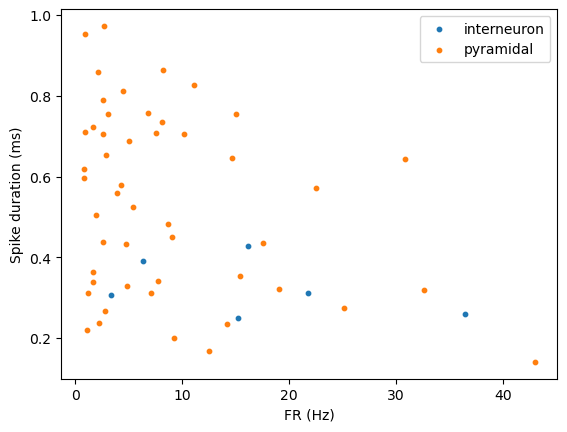

In [5]:
plt.figure()
for typ, sub in df_sessionwise.groupby("putative_type"):
    plt.scatter(sub["fr_hz"], sub["spk_duration_ms"], label=typ, s=10)

#plt.xscale("log")
plt.xlabel("FR (Hz)")
plt.ylabel("Spike duration (ms)")
plt.legend()
plt.show()


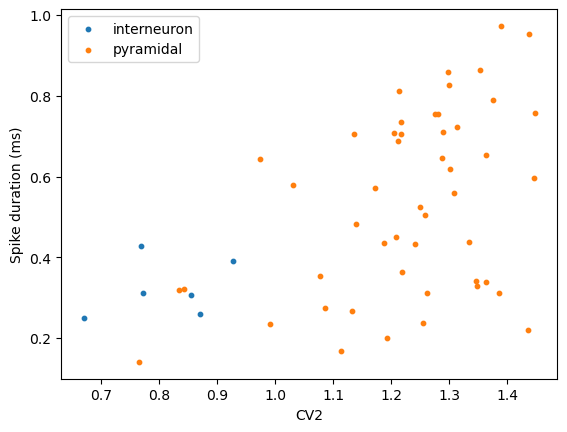

In [47]:
plt.figure()
for typ, sub in df_sessionwise.groupby("putative_type"):
    plt.scatter(sub["cv2"], sub["spk_duration_ms"], label=typ, s=10)

#plt.xscale("log")
plt.xlabel("CV2")
plt.ylabel("Spike duration (ms)")
plt.legend()
plt.show()

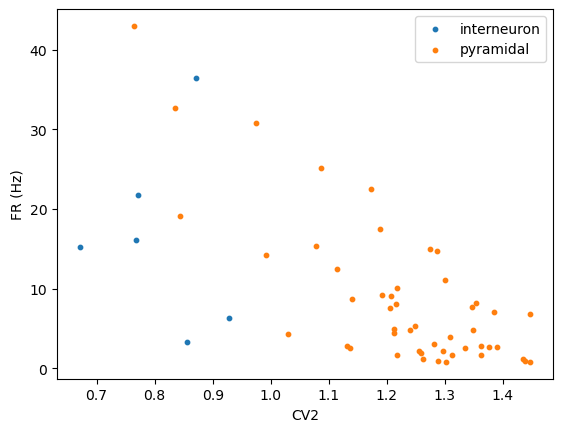

In [48]:
plt.figure()
for typ, sub in df_sessionwise.groupby("putative_type"):
    plt.scatter(sub["cv2"], sub["fr_hz"], label=typ, s=10)

#plt.xscale("log")
plt.xlabel("CV2")
plt.ylabel("FR (Hz)")
plt.legend()
plt.show()

c:\Users\tadse\miniconda3\envs\odors\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


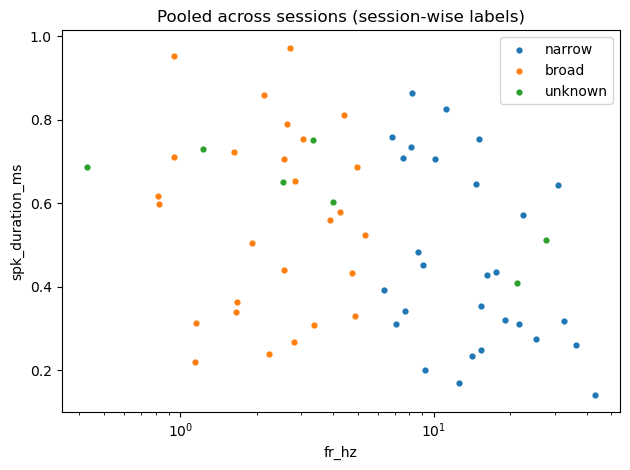

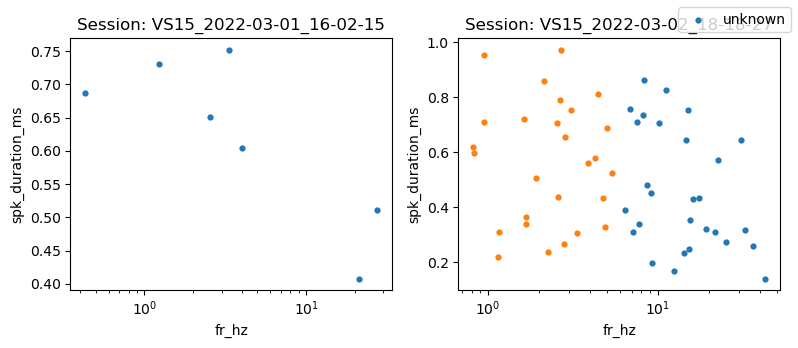

In [49]:

df_labeled = fit_gmm_per_session(df, feature_cols=("log_fr","spk_duration_ms"), min_units=15)

fig_pooled, fig_grid = plot_sessionwise_results(df_labeled)
plt.show()

**Agreggation by age**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [58]:
from pathlib import Path
import pandas as pd

processed_root = Path("../data/processed")  # adjust if needed
excel_path = Path("../data/schedule.xlsx")  # adjust

# --- 1) sessions on disk (from feature parquet files) ---
files = sorted(processed_root.glob("*/features/*_features.parquet"))
disk_sessions = {f.name.replace("_features.parquet", "") for f in files}

print("n feature files:", len(files))
print("n disk sessions:", len(disk_sessions))

# --- 2) sessions in excel ---
meta = pd.read_excel(excel_path, sheet_name='VINCA')
excel_sessions = set(meta["SessionName"].astype(str).str.strip())

print("n excel sessions:", len(excel_sessions))

# --- 3) compare ---
in_excel_not_on_disk = sorted(excel_sessions - disk_sessions)
on_disk_not_in_excel = sorted(disk_sessions - excel_sessions)

print("\nExcel but not on disk:", len(in_excel_not_on_disk))
print("Disk but not in Excel:", len(on_disk_not_in_excel))

# show a few
print("\nExamples Excel-only:", in_excel_not_on_disk[:20])
print("Examples Disk-only:", on_disk_not_in_excel[:20])


n feature files: 65
n disk sessions: 65
n excel sessions: 64

Excel but not on disk: 2
Disk but not in Excel: 3

Examples Excel-only: ['VS121_2025-02-27_17-25-48', 'VS83_2023-05-11_17-15-49']
Examples Disk-only: ['VS11_2022-02-10_17-46-04', 'VS133_2025-12-07_16-27-43', 'VS134_2025-12-06_13-42-18']


In [6]:
# Cell 1: load one age group
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

age_group = "P15_16"  # change: P15_16, P17_18, P19_20, P21_22, P23_24, P25
results_root = Path("../results")

df_age = pd.read_parquet(results_root / age_group / f"{age_group}_clean_units.parquet")
print(f"Loaded {len(df_age)} units for {age_group}")



Loaded 69 units for P15_16


In [7]:
# Cell 2: fit GMM and assign putative cell type
feature_cols = ["log_fr", "spk_duration_ms", "cv2", "acg_peak_latency_ms", "spk_asymmetry", "refractory_ms_edge"]
min_units = 20
random_state = 0

d = df_age.copy()
if "log_fr" not in d.columns:
    d["log_fr"] = np.log10(d["fr_hz"].clip(lower=1e-6))

X_raw = d[feature_cols].to_numpy(dtype=float)
mask = np.isfinite(X_raw).all(axis=1)
d = d.loc[mask].copy()
X = X_raw[mask]

if len(d) < min_units:
    raise ValueError(f"Not enough finite units for GMM: {len(d)} < {min_units}")

# Standardize features
mu = X.mean(axis=0)
sd = X.std(axis=0, ddof=0)
sd[sd == 0] = 1.0
Xz = (X - mu) / sd

gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=random_state)
labels = gmm.fit_predict(Xz)
proba = gmm.predict_proba(Xz)

# cluster with shorter spike duration = interneuron
cluster_mean_dur = pd.DataFrame(
    {"cluster": labels, "dur": d["spk_duration_ms"].to_numpy()}
).groupby("cluster")["dur"].mean()
interneuron_cluster = int(cluster_mean_dur.idxmin())

d["gmm_cluster"] = labels
d["putative_type"] = np.where(labels == interneuron_cluster, "interneuron", "pyramidal")
d["gmm_pmax"] = proba.max(axis=1)

print(d["putative_type"].value_counts())
print(f"Mean confidence (pmax): {d['gmm_pmax'].mean():.3f}")


putative_type
pyramidal      45
interneuron    24
Name: count, dtype: int64
Mean confidence (pmax): 0.981


c:\Users\tadse\miniconda3\envs\odors\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


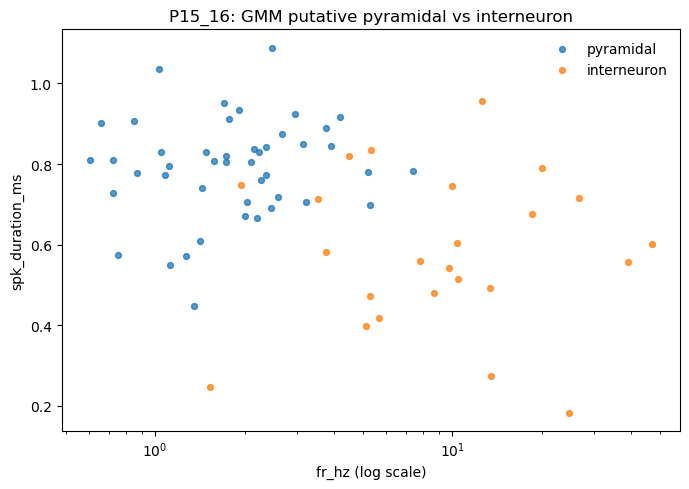

In [8]:
# Cell 3: visualize
fig, ax = plt.subplots(figsize=(7, 5))
for cell_type, color in [("pyramidal", "tab:blue"), ("interneuron", "tab:orange")]:
    s = d[d["putative_type"] == cell_type]
    ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=18, alpha=0.75, label=cell_type, color=color)

ax.set_xscale("log")
ax.set_xlabel("fr_hz (log scale)")
ax.set_ylabel("spk_duration_ms")
ax.set_title(f"{age_group}: GMM putative pyramidal vs interneuron")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# Optional save
# d.to_parquet(results_root / age_group / f"{age_group}_gmm_labels.parquet", index=False)


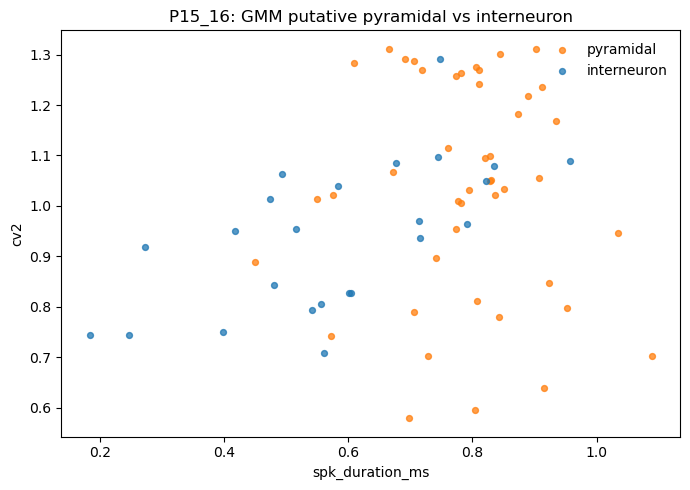

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
for cell_type, color in [("pyramidal", "tab:orange"), ("interneuron", "tab:blue")]:
    s = d[d["putative_type"] == cell_type]
    ax.scatter(s["spk_duration_ms"], s["cv2"], s=18, alpha=0.75, label=cell_type, color=color)

ax.set_xlabel("spk_duration_ms")
ax.set_ylabel("cv2")
ax.set_title(f"{age_group}: GMM putative pyramidal vs interneuron")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# Optional save
# d.to_parquet(results_root / age_group / f"{age_group}_gmm_labels.parquet", index=False)